# **MUHAMMAD ALIF ALFARIZI**

# **1494037162101-564**

**Mengubah Dataset menjadi Dataframe menggunakan library pandas**

In [10]:
import pandas as pd
df = pd.read_csv('bbc-news-data.csv', sep='\t')
df

category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  
0      Quarterly profits at US media giant TimeWarne...  
1      The dollar has hit its highest level against ...  
2      The owners of embattled Russian oil giant Yuk...  
3      British Airways has blamed high fuel prices f...  
4      Shares in UK drinks and food firm Allied Dome...  
...                                                 ...  
2220   BT is introducing two initiatives to help bea...  
2221   Computer users across the world continue to i...  
2222   A new European directive could put software w...  
2223   The man making sure US computer networks are ...  
2224   Online role playing games are time-consuming,...  

[2225 rows x 4 columns]

**Membuang 'filename' dan 'title' karena kita hanya akan menggunakan category sebagai atribut untuk dilatih pada model**

In [11]:
df.drop(['filename', 'title'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   content   2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


**Proses one-hot-encoding dan membuat dataframe baru**

In [12]:
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns=['category'])

In [14]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        2225 non-null   object
 1   business       2225 non-null   uint8 
 2   entertainment  2225 non-null   uint8 
 3   politics       2225 non-null   uint8 
 4   sport          2225 non-null   uint8 
 5   tech           2225 non-null   uint8 
dtypes: object(1), uint8(5)
memory usage: 28.4+ KB


**Mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values**

In [15]:
contents = df_baru['content'].values
label = df_baru[['business', 'entertainment', 'politics', 
                 'sport', 'tech']].values
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

**Melatih Model dan menggunakan fungsi Tokenizer**

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

contents_latih, contents_test, label_latih, label_test = train_test_split(contents, label, test_size=0.2)

tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(contents_latih)
tokenizer.fit_on_texts(contents_test)

sequence_latih = tokenizer.texts_to_sequences(contents_latih)
sequence_test = tokenizer.texts_to_sequences(contents_test)

padded_latih = pad_sequences(sequence_latih)
padded_test = pad_sequences(sequence_test)

**Menerapkan Model Sequential, Embedding, dan LSTM dalam arsitektur model serta Dropout dan Regularizer agar menghindari Overfitting**

In [20]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

**Implementasi Callback pada Epochs**

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.8):
      print('\nAkurasi telah mencapai target')
      self.model.stop_training = True
callbacks = myCallback()

In [22]:
num_epochs = 30
history = model.fit(padded_latih, label_latih, batch_size=64, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2)

Epoch 1/30
28/28 - 11s - loss: 1.9211 - accuracy: 0.2674 - val_loss: 1.4435 - val_accuracy: 0.3708 - 11s/epoch - 397ms/step
Epoch 2/30
28/28 - 3s - loss: 1.3590 - accuracy: 0.3978 - val_loss: 1.6995 - val_accuracy: 0.3708 - 3s/epoch - 115ms/step
Epoch 3/30
28/28 - 3s - loss: 1.2532 - accuracy: 0.4348 - val_loss: 1.3081 - val_accuracy: 0.4045 - 3s/epoch - 115ms/step
Epoch 4/30
28/28 - 3s - loss: 1.1326 - accuracy: 0.4725 - val_loss: 1.2883 - val_accuracy: 0.4539 - 3s/epoch - 115ms/step
Epoch 5/30
28/28 - 3s - loss: 1.0396 - accuracy: 0.5449 - val_loss: 1.3681 - val_accuracy: 0.4045 - 3s/epoch - 117ms/step
Epoch 6/30
28/28 - 3s - loss: 0.8810 - accuracy: 0.6112 - val_loss: 1.2177 - val_accuracy: 0.4989 - 3s/epoch - 116ms/step
Epoch 7/30
28/28 - 3s - loss: 0.8122 - accuracy: 0.6371 - val_loss: 1.2036 - val_accuracy: 0.5348 - 3s/epoch - 116ms/step
Epoch 8/30
28/28 - 3s - loss: 0.7219 - accuracy: 0.6820 - val_loss: 1.5635 - val_accuracy: 0.4719 - 3s/epoch - 114ms/step
Epoch 9/30
28/28 - 3s 

**Plot Loss dan Accuracy**

In [23]:
import matplotlib.pyplot as plt

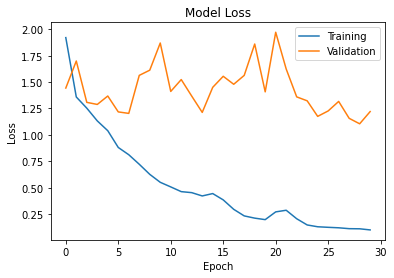

In [31]:
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

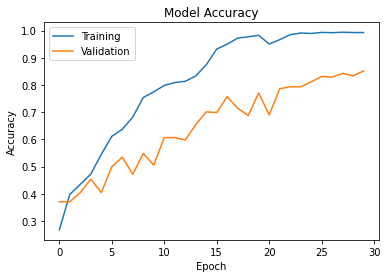

In [32]:
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()